## AutoEncoder

#### 차원의 저주

차원이 증가하면 그것을 표현하기 위한 데이터의 수가 기하급수적으로 증가한다.

(일정 차원이 넘으면 분류기의 성능은 점점 떨어져 0으로 수렴함)

AE는 입력값보다 작은 차원을 갖는 hidden layer를 이용해 데이터 속에 숨어있는 변수를 발굴할 수 있게 해준다.

흔히 사용되는 PCA는 선형적인 한계가 있다. 하지만 AE는 뉴런이 갖고 있는 non-linear 및 constraints로 인해 훨씬 뛰어난 차원 축소 능력을 가지고 있다.


<VAE와 AE의 차이>

VAE는 AE와 비슷하지만 약간 다른점이 존재한다. z가 training data와 특별이 관련이 없이 단순히 계산 중간에 나오는 한 값일 뿐이라면 VAE에서의 latent variable인 z는 continouous한 분포를 갖는 random variable이라는 점이 중요한 차이다. 이 latent variable z의 분포는 training 과정에서의 data로부터 학습된다.
(즉, VAE는 z를 좀 더 다루기 쉬운 우리가 잘 아는 분포(가우시안)의 형태를 띄게 만들어 지는 것

결론적으로, AE와 다른 점은 z 하나하나를 "모으고", "흔들어서", z 공간을 더 촘촘히 채워줘서 더 유용한 z 공간을 만든다는 것

http://blog.naver.com/PostView.nhn?blogId=laonple&logNo=220880813236&parentCategoryNo=&categoryNo=18&viewDate=&isShowPopularPosts=true&from=search

PCA vs VAE vs GAN
https://spark-in.me/post/playing-with-vae-umap-pca

In [ ]:
### IN 파일

1. 

In [201]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from random import *

## 사전 변경값 확인

In [202]:
# 구분 최초 설정 필요

df = 'core'
target_temp_df = 'Y'  # 정상:부실의 데이터 비율을 맞추기 위한 데이터셋을 사용할 건지 여부 (데이터스케일링 쥬피터 결과 기준)

# main/all/core 3가지로 설정 




# core설정시 확인해야 함
# R을 통해 확인한 stepwise 유의 변수 리스트
core_factors = ['DR00000136','6000201001O0','6000903016D1','FNMKFN02','6000901002D1','S41000210FD1',
'6000207003O0','DR00000052','6000906001D6','DR00000156','6000901001D3','DR00000082',
'S41000210FD2','6000902001D2','6000908001D3','6000904001D3','6000908001D2','S41B0D1009O0',
'6000901002D3','6000903001D2','6000403001O0','CO10100170O0','DR00000113','6000908001D7']

#  키별로 비율 배분이 잘 됐는지 확인
if df == 'all':
    max_idx = 707
else:
    max_idx = 124
    

## 데이터셋 셋팅

In [203]:
import pickle # 파이썬 객체저장을 위한 모듈

# 파이썬 객체 읽어오기

if target_temp_df != 'Y':
    if df == 'all':
        with open('./pickles/dataset_all.p', 'rb') as file:    # hello.txt 파일을 바이너리 읽기 모드(rb)로 열기
            train_set = pickle.load(file)
            test_set = pickle.load(file)
    else:
        with open('./pickles/dataset_main.p', 'rb') as file:    # hello.txt 파일을 바이너리 읽기 모드(rb)로 열기
            train_set = pickle.load(file)
            test_set = pickle.load(file)
else:
# 정상:부실의 데이터 비율 조정 기준
    if df == 'all':
        with open('./pickles/data6vs4_all.p', 'rb') as file:    # hello.txt 파일을 바이너리 읽기 모드(rb)로 열기
            temp_train_set = pickle.load(file)
            temp_test_set = pickle.load(file)
            af_cols = pickle.load(file)
    else:
        with open('./pickles/data6vs4_main.p', 'rb') as file:    # hello.txt 파일을 바이너리 읽기 모드(rb)로 열기
            temp_train_set = pickle.load(file)
            temp_test_set = pickle.load(file)
            af_cols = pickle.load(file)
            
    # 필요없는 열 삭제
    train_set = temp_train_set.drop(['index', 0, max_idx-1,max_idx],axis=1)  # 열삭제
    test_set = temp_test_set.drop(['index', 0, max_idx-1,max_idx],axis=1)  # 열삭제
    x_train.shape, y_train.shape, x_test.shape, y_test.shape

    # 항목명 (열명) 셋팅
    factor_cols = list(af_cols[1:-2])
    train_set.columns = factor_cols
    test_set.columns = factor_cols


In [204]:
# core인 경우 main에서 핵심 변수만 추림

if df == 'core':
    final_factors = ['key', 'industry', 'label']
    final_factors = final_factors + core_factors
    train_set = train_set[final_factors]
    test_set = test_set[final_factors]
else:
    pass

In [205]:
df, train_set.shape, test_set.shape

('core', (755, 27), (333, 27))

### 데이터 분리 및 타입변경

In [206]:
# 데이터 분리
cols = train_set.columns.values
train_info = train_set[cols[0:3]]
x_train = train_set[cols[3:]]
y_train = train_set['label']
train_len = x_train.shape[0]

cols = test_set.columns.values
test_info = test_set[cols[0:3]]
x_test = test_set[cols[3:]]
y_test = test_set['label']
test_len = x_test.shape[0]

In [207]:
x_train.shape, y_train.shape

((755, 24), (755,))

## VAE 모델링 ------------------------------------------------------------------------------

In [208]:
m = x_train.shape[1] # 가로 열, 주의! 설명항목 제외
n = x_train.shape[0] # 세로 행 
original_dim = m 
intermediate_dim = 256

# latent vector  z 의 차원   32
if m >= 100:
    latent_dim = 32
elif m >= 50:
    latent_dim = 16
else:
    latent_dim = 10
    
batch_size = 100 # 100
epochs = 50   # 50
epsilon_std = 1 # 1.0

VAE loss 함수 참고
https://www.facebook.com/groups/TensorFlowKR/permalink/524873987853664/

In [209]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):
    
    """
    KL을 사용하는 의미는 q0(z|x) ( x 를 받고 z 를 뱉어내는 인코더 ) 와 
    p(z) = Normal distribution (mean= 0 stddv = 1) 의 정보량의 차이가 얼마나 나는가를 보기 위해 사용
    """
    
    """ 
    VAE loss = reconstruction_loss + regularizaion_loss
    
    1) reconstruction : AE의 입력 X와 출력 X'의 차이에 대한 loss
    2) reqularization : -0.5 * (1 + log_z_var - z_mean^2 - z_var)
       z_mean과 z_var는 z들의 (다시 말해 z 전체의) mean과 var가 아니다. 
       z 각각, 하나하나의 mean과 var이다. 하나하나의 mean과 var 용어 때문에 헷갈린다면 
       (AE에서의 z와 같은) z와 z_흔들기정도 정도로 이해하면 더 쉽다.
       x 하나하나에 대한 z 하나하나를 확률적으로 보고 학습 하겠다는 것이다.
       
    * z_var - log_z_var는 z_var가 1일때 최소화 된다. 즉, z_var를 1에 가깝게, 1보다 너무 크지도 작지도 않게 하라는 뜻이다
      "랜덤하게 흔드는" 것을 어느 정도는 적당히 흔들어 주라는 뜻이 된다. 그래야 거기서 얘기한 "공간 채우기" 효과를 낼 수 있기 때문이다.
      
    """
    
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

    


In [210]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

"""
z를 학습할때마다 랜덤하게 흔들어줌
z공간을 더 많이 학습된 공간으로 채워 준다. 결국 Decoder 입장에서 z 공간이 훨씬 더 믿을 만한 (유용한) 공간이 됨
"""
eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

### 모델 fit

In [211]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(-1, original_dim)
x_test = x_test.reshape(-1, original_dim)

In [212]:
x_train.shape, x_test.shape

((755, 24), (333, 24))

In [213]:
hist = vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_train,x_train))

encoder = Model(x, z_mu)

Train on 755 samples, validate on 755 samples
Epoch 1/50
755/755 [==============================] - 2s 2ms/step - loss: -17.2289 - val_loss: -134.8250
Epoch 2/50
755/755 [==============================] - 0s 70us/step - loss: -258.3753 - val_loss: -365.1105
Epoch 3/50
755/755 [==============================] - 0s 86us/step - loss: -391.8857 - val_loss: -429.1524
Epoch 4/50
755/755 [==============================] - 0s 74us/step - loss: -441.1714 - val_loss: -463.6643
Epoch 5/50
755/755 [==============================] - 0s 75us/step - loss: -472.8354 - val_loss: -486.3717
Epoch 6/50
755/755 [==============================] - 0s 71us/step - loss: -490.5702 - val_loss: -501.8057
Epoch 7/50
755/755 [==============================] - 0s 86us/step - loss: -504.8860 - val_loss: -512.3602
Epoch 8/50
755/755 [==============================] - 0s 81us/step - loss: -515.1018 - val_loss: -514.9441
Epoch 9/50
755/755 [==============================] - 0s 91us/step - loss: -521.5238 - val_loss: -52

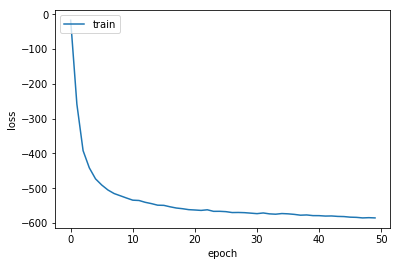

In [214]:
# 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


In [215]:
z_train = encoder.predict(x_train, batch_size=batch_size)
z_test = encoder.predict(x_test, batch_size=batch_size)

In [216]:
z_train.shape, z_test.shape

((755, 10), (333, 10))

In [217]:
z_train

array([[-0.83958435, -0.3021657 , -0.96403253, ..., -1.0492758 ,
        -0.983578  , -2.1865983 ],
       [-0.6436971 , -0.23082763, -0.5861949 , ..., -0.18810788,
        -1.4622672 , -1.6269703 ],
       [-1.0581148 ,  1.6171075 ,  0.2241547 , ...,  0.697038  ,
        -0.4279828 ,  0.4540967 ],
       ...,
       [-0.07294971, -0.71697307, -2.2183113 , ..., -0.32586256,
        -0.89865613, -1.7639611 ],
       [ 0.15232477,  1.02123   , -1.992648  , ..., -3.0430787 ,
         0.9377557 , -0.5586691 ],
       [ 0.50714535,  1.053878  , -1.9514117 , ..., -2.5293362 ,
         1.3194729 ,  0.4116425 ]], dtype=float32)

In [218]:
x_train

array([[0.0, 0.4878479898113108, -0.23557822307347814, ...,
        0.2047541382419316, 0.0, 1.0],
       [0.0, 1.8098741311576565, 0.7469760522524025, ...,
        0.27794649101708274, 0.0, 0.0],
       [0.0, 1.8098741311576565, 0.3159554267026738, ...,
        0.5434321963520068, 0.0, 0.0],
       ...,
       [0.0, 1.8098741311576565, -0.9248494901570484, ...,
        0.5434321963520068, 0.0, 1.0],
       [3.0, 1.8098741311576565, -0.923382115585833, ...,
        0.5434321963520068, 0.0, 1.0],
       [3.0, 1.8098741311576565, -0.9827779300879173, ...,
        0.5434321963520068, 0.0, 1.0]], dtype=object)

In [219]:
# 변수저장
import pickle # 파이썬 객체저장을 위한 모듈

if df == 'all':
    file_nm = './pickles/vae_all.p'
elif df == 'main':
    file_nm = './pickles/vae_main.p'
elif df == 'core':
    file_nm = './pickles/vae_core.p'
   
    
    
# 파이썬 객체 상태로 저장하기
with open(file_nm, 'wb') as file:  # hello.txt 파일을 바이너리 쓰기 모드(wb)
    pickle.dump(z_train, file)
    pickle.dump(z_test, file)
    pickle.dump(y_train, file)
    pickle.dump(y_test, file)
    pickle.dump(train_set, file)
    pickle.dump(test_set, file)